<h1><center>Проведение EDA. Практика</center></h1>

Вернёмся к задаче оттока для компании «Космолайн», которую вы решали в предыдущих темах. После каждого пройденного урока вам нужно понемногу улучшать свой пайплайн и с точки зрения качества модели, и с точки зрения скорости работы в продакшене. 

Начнём с проведения разведочного анализа данных, или EDA.

Для начала определите среду выполнения анализа и задайте глобальные переменные, которые понадобятся вам в ходе решения задач. Название эксперимента можете взять из предыдущих уроков. Переменная ASSETS_DIR хранит название директории, где, в свою очередь, хранятся артефакты, полученные в ходе первичного анализа данных. А ещё, проводя EDA, вы можете увеличить стандартное значение отображаемых колонок и строк, а также установить стили графиков — зачастую это полезно.

In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "clean_users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "test_connection_experiment_1" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

Затем загрузите данные для обучения модели, как вы это делали в предыдущих уроках.

In [2]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {"host": 'rc1b-uh7kdmcx67eomesf.mdb.yandexcloud.net', #os.getenv("DB_DESTINATION_HOST"),
                        "port": '6432', #os.getenv("DB_DESTINATION_PORT"),
                        "dbname": 'playground_mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_NAME"),
                        "user": 'mle_20250529_05fed48463', #os.getenv("DB_DESTINATION_USER"),
                        "password": '0c567edd8ad8472e87d5c85cc4d664e4' } #os.getenv("DB_DESTINATION_PASSWORD")}
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)
df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,1,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No,None
1,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,None


**Задание 1**

Постройте графики количества уникальных пользователей (customer_id), распределённых по таким группам:
- пользователи по различным type,
- пользователи по различным payment_method,
- пользователи по различным internet_service,
- пользователи по различным gender.


Создайте одну фигуру размером 16.5x12.5 с четырьмя графиками по списку выше. Сохраните вашу картинку в директорию ASSETS_DIR, а файл назовите cat_features_1.

/tmp/ipykernel_3616/2889844888.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);


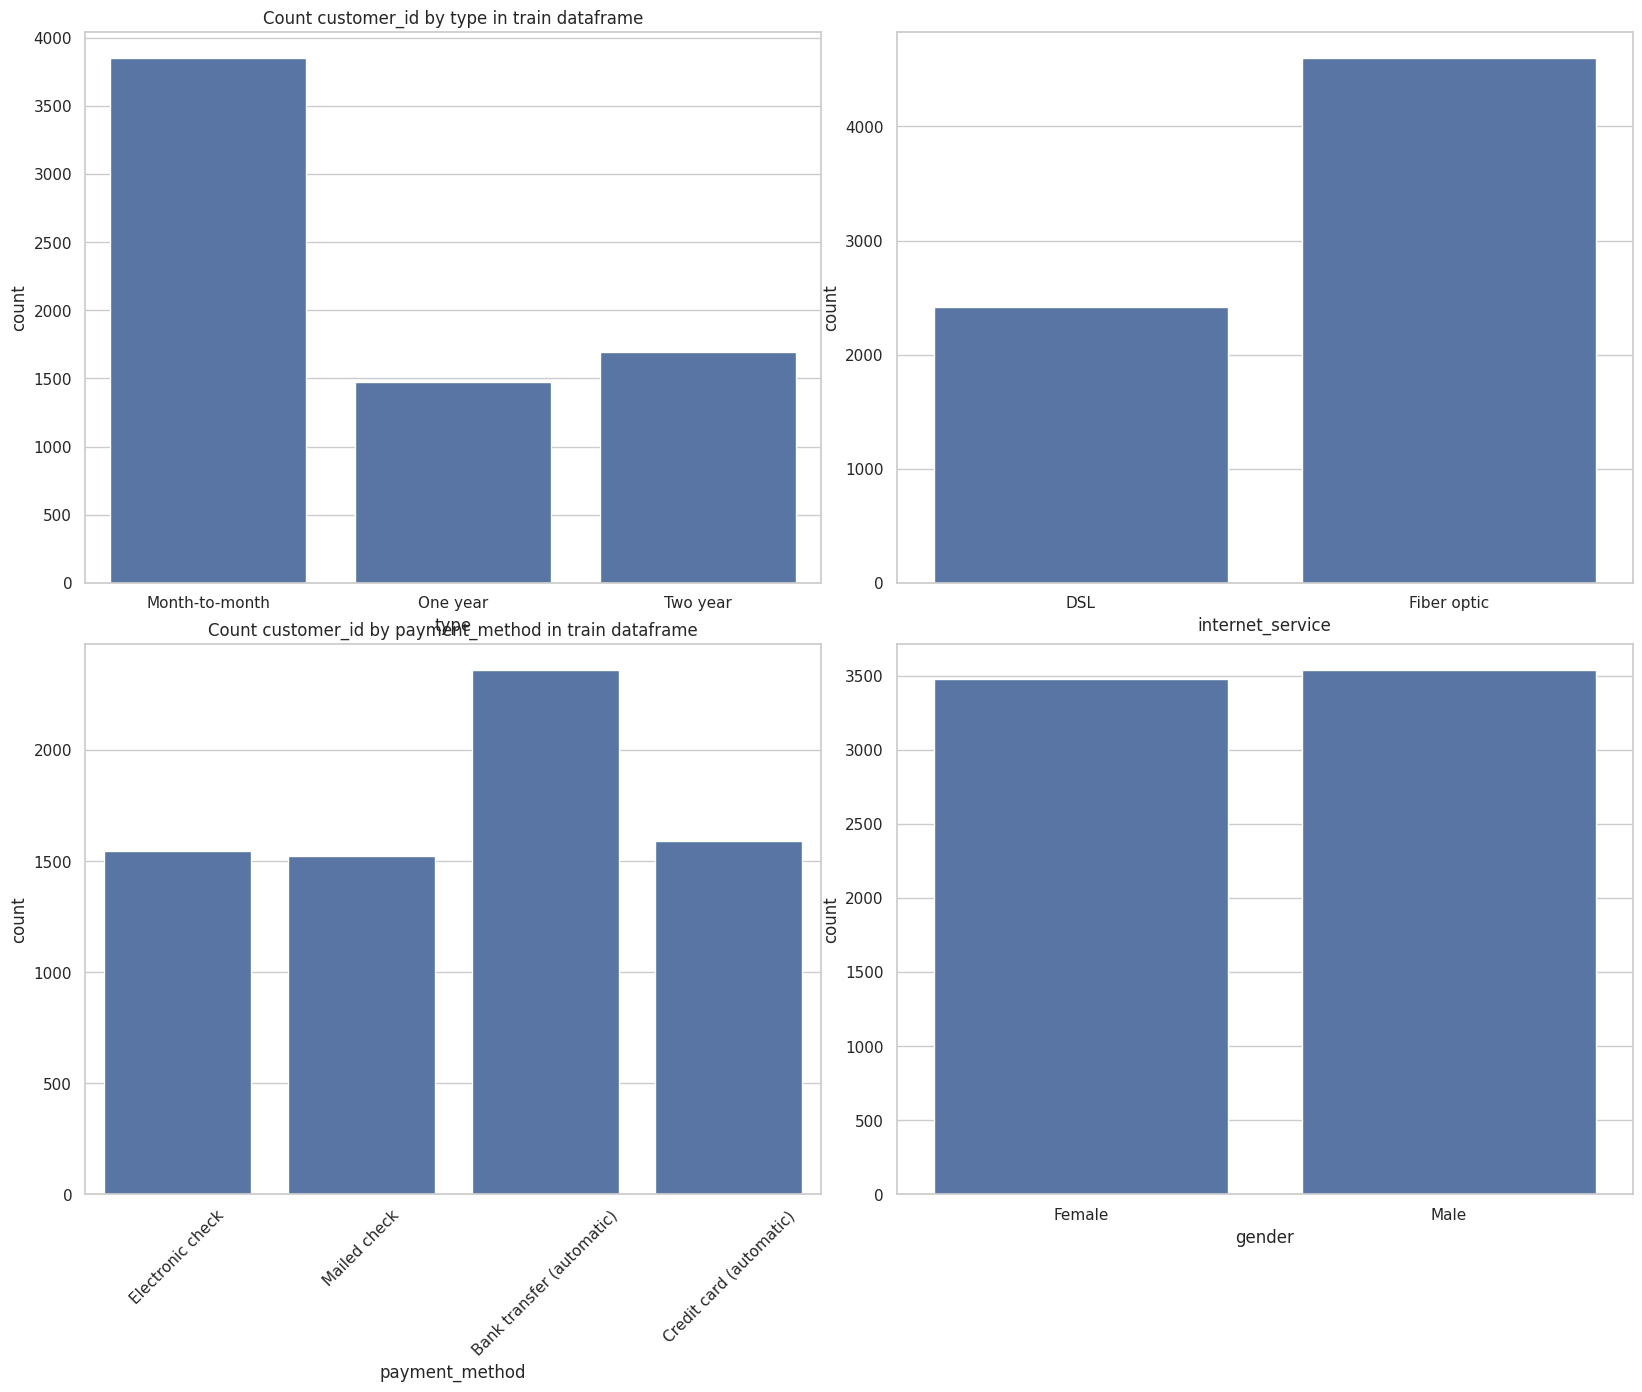

In [3]:
fig, axs = plt.subplots(2, 2)# ваш код тут #
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=1.6)


x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x)[y].agg(stat).reset_index() # ваш код тут #
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 0])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[0, 0]) # ваш код тут #
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
# ваш код тут #
agg_df = df.groupby(x)[y].agg(['count']).reset_index()
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 0])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = df.groupby(x)[y].agg(stat).reset_index()  # Группировка данных
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[0, 1])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[0, 1])  # Построение графика

x = "gender"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = df.groupby(x)[y].agg(stat).reset_index()  # Группировка данных
sns.barplot(data=agg_df, x=x, y=stat[0], ax=axs[1, 1])
#sns.barplot(data=agg_df, x=x, y='count', ax=axs[1, 1])  # Построение графика

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

**Задание 2** Карта бинарных признаков:

In [4]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count'] # ваш код здесь

binarnaya = df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False)
binarnaya[-3:]

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
219,Yes,No,No,No,No,No,1,No,Yes,1
147,No,Yes,No,Yes,Yes,No,0,No,Yes,1
280,Yes,No,Yes,No,Yes,No,1,No,No,1


**Задание 3** Хитмеп для бинарных признаков:

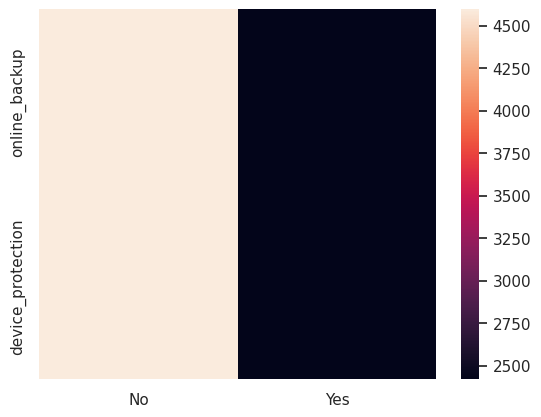

In [5]:
heat_df = df[['online_backup','device_protection']].apply(pd.Series.value_counts).T # ваш код здесь #)
sns.heatmap(heat_df)
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

**Задание 4**

Постройте два графика для monthly_charges и total_charges, а затем посчитайте средние значение, медиану и моду для каждого begin_date на них. Получившийся график сохраните с названием charges_by_date.

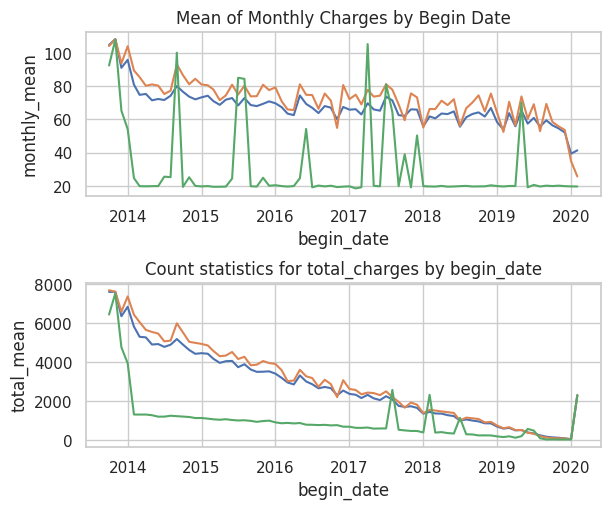

In [6]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [ "monthly_charges","total_charges" ]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index() # ваш код здесь #
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index() # ваш код здесь #
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1) # ваш код здесь #
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей

sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
axs[0].set_title("Mean of Monthly Charges by Begin Date")

sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
# axs[1].set_title("Median of Monthly Charges by Begin Date")

sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# axs[2].set_title("Mode of Monthly Charges by Begin Date")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
# axs[3].set_title("Mean of Total Charges by Begin Date")

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
# axs[4].set_title("Median of Total Charges by Begin Date")

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# axs[5].set_title("Mode of Total Charges by Begin Date") # ваш код здесь #
# установка заголовка для верхнего графика
# axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
# charges_total_agg.plot(x=x, y=['total_mean', 'total_median', 'total_mode'], ax=axs[1])

# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

# сохранение графика в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date')) # ваш код здесь #

**Задание 5**

Постройте график распределения количества 0 и 1 в вашем датасете. Сохраните график с именем target_count.

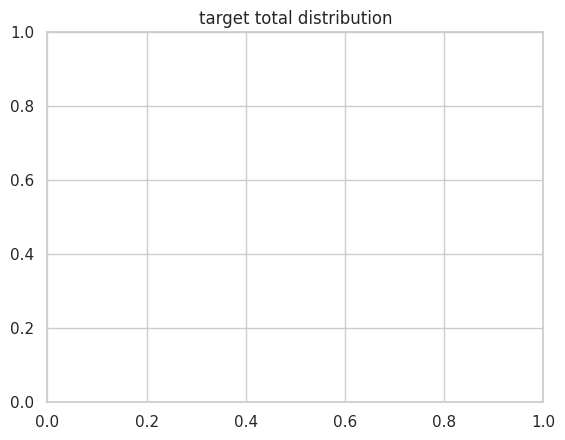

In [7]:
# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index() # ваш код здесь #

# создание столбчатой диаграммы для визуализации распределения целевой переменной
# target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
sns.barplot(data=target_agg) # ваш код здесь #

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count')) # ваш код здесь #

**Задание 6**

Постройте четыре графика, отражающих следующие зависимости целевой переменной от признаков:
- количество 1 в целевой переменной в зависимости от даты,
- количества 1 и 0 в целевой переменной в зависимости от даты,
- конверсия (количество1, поделённое на общий размер датасета) в зависимости от даты,
- конверсия в зависимости от пола.

График поможет лучше понять природу ваших данных, чтобы учитывать её при обучении модели. Получившуюся картинку сохраните с именем target_by_date.

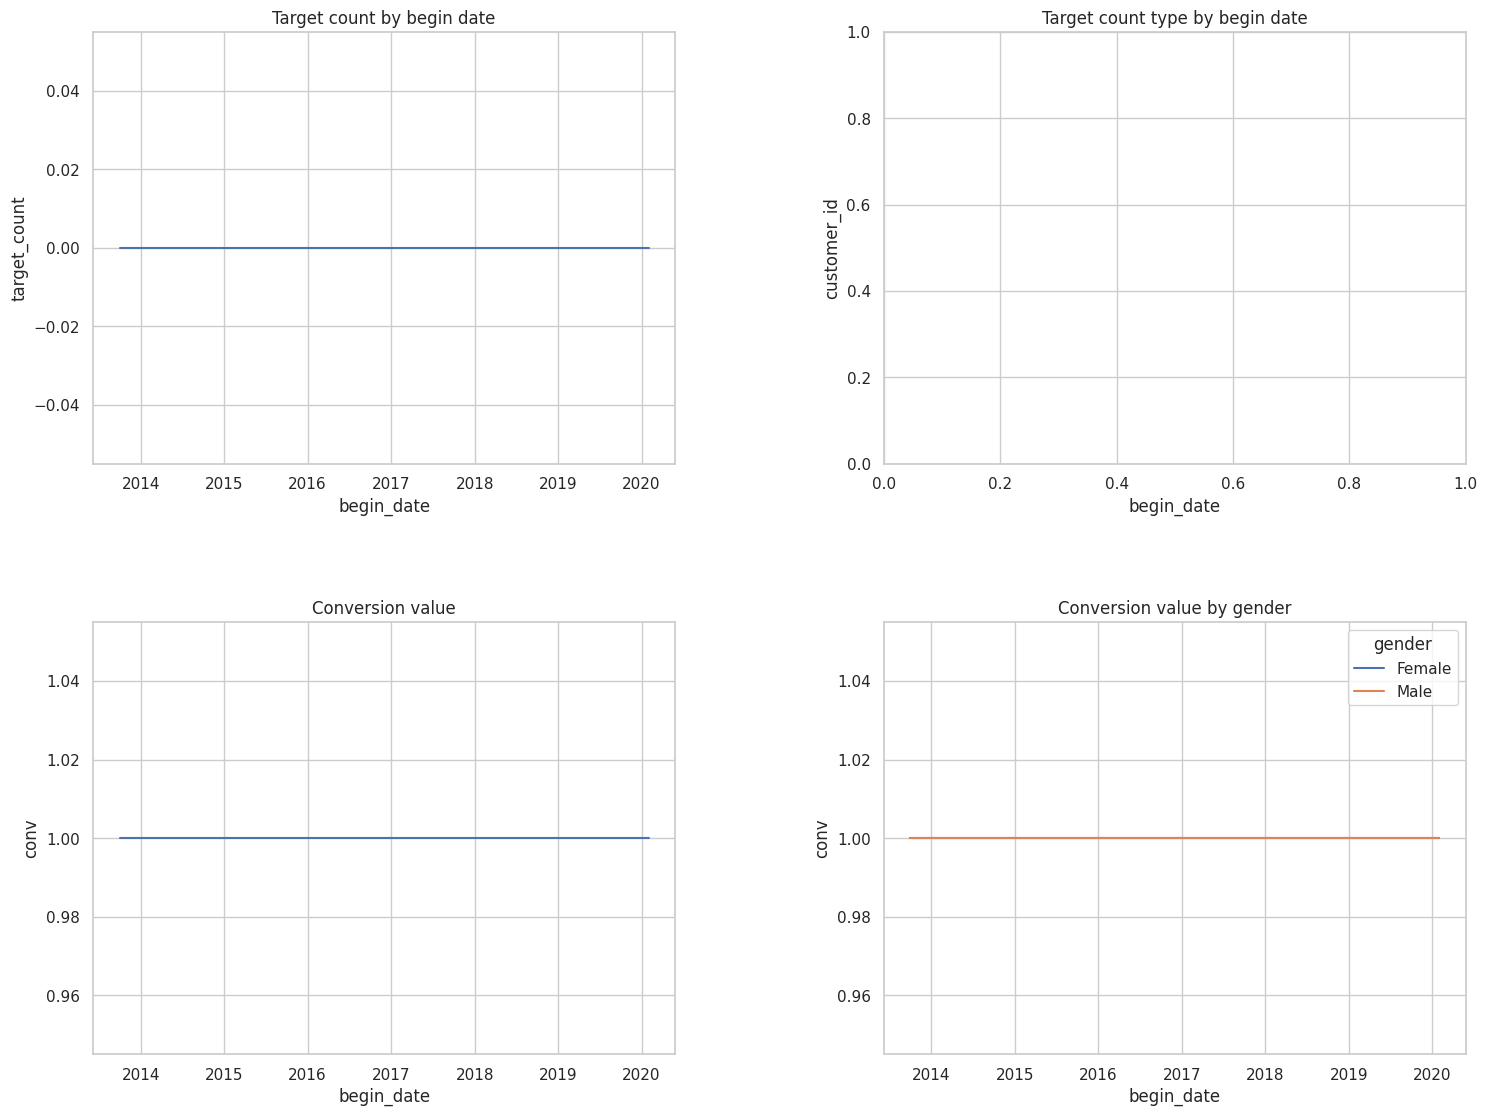

In [8]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index() # ваш код здесь #
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index() # ваш код здесь #

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum','count']).reset_index() # ваш код здесь #
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = 1 #(conversion_agg['sum'] / conversion_agg['count']).round(2) # ваш код здесь #

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index() # ваш код здесь #
successful_conversions = df[df[target] == 1].groupby([x, 'gender'])['customer_id'].count()
conversion_agg_gender["conv"] = 1 #(conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2) # ваш код здесь #

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
# ваш код здесь #
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
#fig, axs = plt.subplots(2, 2)
#fig.tight_layout(pad=1.6) 
#fig.set_size_inches(16.5, 12.5, forward=True)

# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
# ваш код здесь #
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

**Задание 7**

Постройте графики распределения monthly_charges и total_charges для каждого события. График отобразите с оценкой плотности, а затем сохраните с названием chargest_by_target_dist.

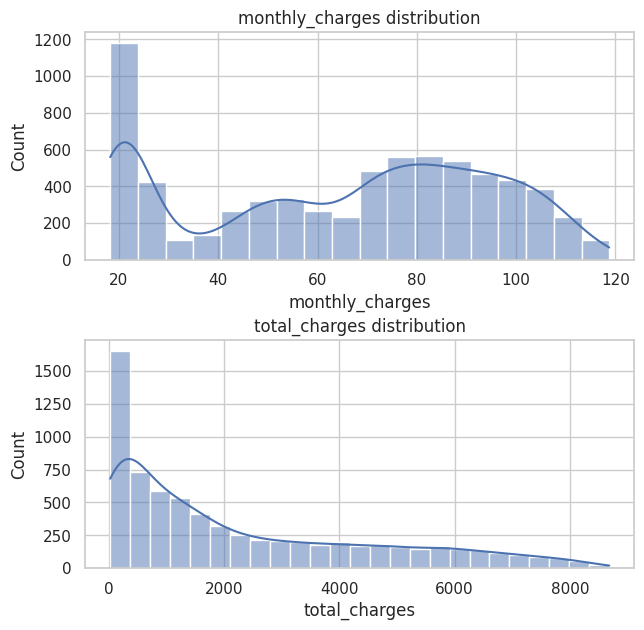

In [9]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
sns.histplot(data=df, x=charges[0], kde=True, ax=axs[0])
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
sns.histplot(data=df, x=charges[1], kde=True, ax=axs[1])
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
# ваш код здесь #
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

При анализе важно ничего не потерять, особенно получившиеся на выходе артефакты. Сохраните их в директорию ASSETS_DIR при помощи MLflow. Сделать это можно следующим образом:

In [15]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 's3-student-mle-20250529-05fed48463'
os.environ["AWS_ACCESS_KEY_ID"] = "YCAJE3Nlz8iDILW5VTYM1ihQB"
os.environ["AWS_SECRET_ACCESS_KEY"] = "YCPjvS7uwhvJpUj3bKm8X-IX4QAwBIVsvX61IL44"

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

ValueError: Invalid endpoint: s3-student-mle-20250529-05fed48463